# MRI

MRI with deep decoder; comparison to l1-minimization and TV minimization

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

import h5py
from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Load MRI images

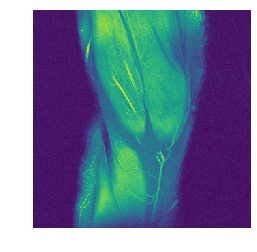

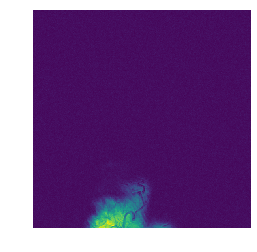

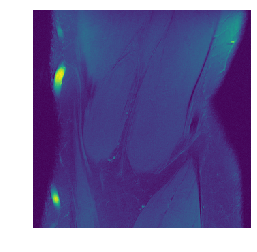

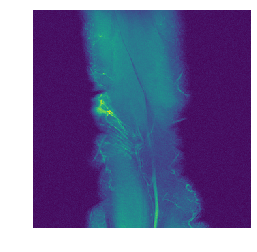

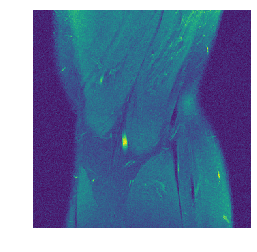

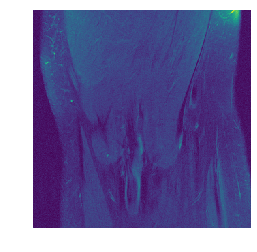

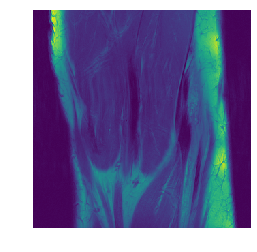

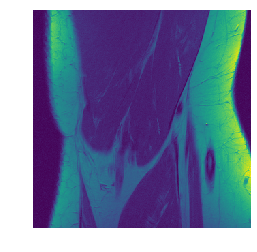

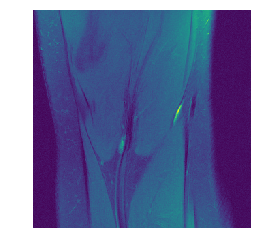

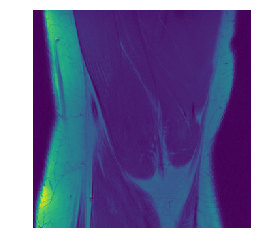

got  10  images of shape  torch.Size([1, 1, 320, 320])


In [2]:
def get_mri_imgs(mfiles = 100,path = './fastMRI-master/singlecoil_val/'):
    imgs = []
    imgnames = [f for f in listdir(path) if isfile(join(path, f))]
    for i,imgname in enumerate(imgnames):
        filename = path + imgname#'./fastMRI-master/singlecoil_val/file1001077.h5'
        f = h5py.File(filename, 'r')
        #print("Keys: %s" % f.keys())
        # Get the data
        data = list(f['reconstruction_rss'])
        img_np = data[-1] # the best reconstruction from multicoil
        img_np = img_np/np.max(img_np) # scale
        imgs += [img_np]
        if i>=mfiles-1:
            break
    return imgs

# get 100 images
imgs = get_mri_imgs(10)

# plot example images

for img_np in imgs:
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

whshape = img_np.shape

img_var = np_to_var( np.array([img_np]) ).type(dtype)

print("got ", len(imgs), " images of shape ", img_var.shape )

## Define forward model

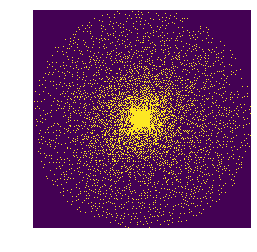

In [3]:
# Undersample
accel = 10  # Acceleration factor
mask2d = mr.poisson( whshape , accel=accel, calib=[24, 24]).astype(float)

mask = Variable( torch.zeros( (1,1,) + whshape + (2,) ) ).type(dtype)
mask[0,:,:,:,0] = np_to_var(mask2d)
mask[0,:,:,:,1] = np_to_var(mask2d)


def forwardm(img,mask=mask):
    fimg = Variable( torch.zeros(img.shape + (2,) ) ).type(dtype)
    fimg[:,:,:,:,0] = img
    Fimg = transforms.fft2(fimg)
    return Fimg*mask

out = forwardm(img_var)

def lsreconstruction(measurement):
    fimg = transforms.ifft2(measurement)
    return fimg[:,:,:,:,0]
    
measurement = forwardm(img_var).type(dtype)
lsimg = lsreconstruction(measurement)


plt.imshow(np.clip( var_to_np(mask)[0,:,:,1] ,0,1))
plt.axis('off')
plt.show()

## L1 wavelet reconstruction

In [4]:
def get_l1wav(img_np):
    mask2d = mr.poisson( img_np.shape , accel=accel, calib=[24, 24]).astype(float)
    y = sp.fft(img_np)*mask2d
    F = sp.linop.FFT(img_np.shape)
    P = sp.linop.Multiply(img_np.shape, mask2d)
    A = P * F
    print(A)

    lamda = 0.001
    W = sp.linop.Wavelet(img_np.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)

    img_l1wav = sp.app.LinearLeastSquares(A, y, proxg=proxg).run()
    img_l1wav = img_l1wav.astype(float)
    #img_var = np_to_var( np.array([img_l1wav]) ).type(dtype)
    return img_l1wav

img_l1wav = get_l1wav(img_np)

MaxEig:  47%|████▋     | 14/30 [00:00<00:00, 138.00it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 35.65it/s, resid=1.23E-02]


## Total variation

In [5]:
def get_TV(img_np):
    mask2d = mr.poisson( img_np.shape , accel=accel, calib=[24, 24]).astype(float)
    y = sp.fft(img_np)*mask2d
    F = sp.linop.FFT(img_np.shape)
    P = sp.linop.Multiply(img_np.shape, mask2d)
    A = P * F

    lamda = 0.02 # best of: 0.001, 0.005, 0.01, 0.02, 0.05
    #W = sp.linop.Wavelet(ksp_np.shape)
    #proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    G = sp.linop.Gradient(img_np.shape)
    proxg = sp.prox.L1Reg(G.oshape, lamda)
    
    img_TV = sp.app.LinearLeastSquares(A, y, proxg=proxg,G=G).run()
    return img_TV.astype(float)

img_tv = get_l1wav(img_np)

MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 142.10it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 37.63it/s, resid=1.23E-02]


# Quantitative experiments

In [6]:
def simulate_dd(func):
    psnrs = []
    print("will average over ", len(imgs), "images")
    for i,img_np in enumerate(imgs):
        img_var = np_to_var( np.array([img_np]) ).type(dtype)
        out_img_var = func(img_var)
        out_img_np = out_img_var.data.cpu().numpy()[0]
        img_np = img_var.data.cpu().numpy()[0]
        psnrs += [psnr(img_np,out_img_np)]
        print(i,np.mean(psnrs))
    return psnrs

## Standard deep decoder

In [7]:
def dd_recovery(img_var):
    measurement = forwardm(img_var).type(dtype)
    num_channels = [k]*5
    net = decodernw(1,num_channels_up=num_channels).type(dtype)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0,num_iter=num_iter,LR = 0.0025,
                        img_noisy_var=measurement,
                        net=net,apply_f = forwardm,img_clean_var=img_var,
                        upsample_mode='bilinear',
                        )
    out_img_var = net( ni.type(dtype) )
    return out_img_var


num_iter=15000

k = 128
psnrs128 = simulate_dd(dd_recovery)

k = 256
psnrs256 = simulate_dd(dd_recovery)

k = 320
psnrs320 = simulate_dd(dd_recovery)

will average over  10 images
input shape:  [1, 128, 10, 10]
optimize with adam 0.0025
0 32.57799772085757Train loss 0.000022  Actual loss 0.000540 Actual loss orig 0.000540 
input shape:  [1, 128, 10, 10]
optimize with adam 0.0025
1 35.470684564889645rain loss 0.000008  Actual loss 0.000149 Actual loss orig 0.000149 
input shape:  [1, 128, 10, 10]
optimize with adam 0.0025
2 35.612972451125565rain loss 0.000016  Actual loss 0.000259 Actual loss orig 0.000259 
input shape:  [1, 128, 10, 10]
optimize with adam 0.0025
3 35.37660069078877Train loss 0.000015  Actual loss 0.000344 Actual loss orig 0.000344 
input shape:  [1, 128, 10, 10]
optimize with adam 0.0025
4 34.16596813354674Train loss 0.000042  Actual loss 0.001184 Actual loss orig 0.001184 
input shape:  [1, 128, 10, 10]
optimize with adam 0.0025
5 33.89859285727769Train loss 0.000019  Actual loss 0.000557 Actual loss orig 0.000557 
input shape:  [1, 128, 10, 10]
optimize with adam 0.0025
6 33.70422559345848Train loss 0.000042  Actu

## l1 minimization

In [10]:
def simulate_np(func):
    psnrs = []
    for i,img_np in enumerate(imgs):
        out_img_np = func(img_np)
        psnrs += [psnr(img_np,out_img_np)]
        print(i,np.mean(psnrs))
    return psnrs   

psnrsl1 = simulate_np(get_l1wav)

MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 154.10it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 40.11it/s, resid=1.70E-02]


0 31.04203240134471


MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 136.87it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 40.54it/s, resid=1.27E-02]


1 35.22359389643774


MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 140.97it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 43.05it/s, resid=9.71E-03]


2 35.32703129900569


MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 145.10it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 38.91it/s, resid=1.17E-02]


3 35.017101926530685


MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 149.22it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 38.47it/s, resid=1.50E-02]


4 33.78346089117901


MaxEig:  93%|█████████▎| 28/30 [00:00<00:00, 161.87it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 41.11it/s, resid=1.08E-02]


5 33.534657449322275


MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 143.41it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 40.63it/s, resid=1.45E-02]


6 33.3382744159925


MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 152.96it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 38.63it/s, resid=1.79E-02]


7 33.038249679999645


MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 141.69it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 35.84it/s, resid=1.03E-02]


8 33.05179064281928


MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 148.63it/s, max_eig=1.00E+00]

<[320, 320]x[320, 320]> Multiply * FFT Linop>


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 36.57it/s, resid=1.23E-02]

9 33.19637388471656


In [12]:
psnrstv = simulate_np(get_TV)
print(np.mean(psnrstv))

LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 34.49it/s, resid=7.55E-03]


0 31.380821104364067


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 35.81it/s, resid=2.75E-02]


1 34.68053761934344


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 35.40it/s, resid=3.35E-03]


2 34.96954458662046


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 34.56it/s, resid=5.92E-03]


3 34.65119227471543


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 34.55it/s, resid=3.06E-03]


4 33.50411337022607


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 36.09it/s, resid=2.16E-03]


5 33.27038157623647


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 35.46it/s, resid=7.24E-03]


6 33.18866491301117


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 35.36it/s, resid=1.60E-02]


7 33.12061066750551


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 35.06it/s, resid=3.00E-03]


8 33.120256070583906


LinearLeastSquares: 100%|██████████| 100/100 [00:02<00:00, 35.42it/s, resid=7.12E-03]

9 33.37346805060524
33.37346805060524


In [13]:
print("deep decoder")
print(np.mean(psnrs128))
print(np.mean(psnrs256))
print(np.mean(psnrs320))

print("TV")
print(np.mean(psnrstv))

print("l1")
print(np.mean(psnrsl1))

5000 iterations
33.92427324774279
34.39810853487948
34.43298558529767
10000 iterations
34.51292872660905
34.7446732364703
34.603967251347285
TV
33.37346805060524
l1
33.19637388471656
